In [1]:
import importlib
import logging
import nanomotif as nm
import polars as pl
import matplotlib.pyplot as plt
import networkx as nx
importlib.reload(nm)
logging.basicConfig(level=logging.INFO)

In [2]:
def plot_search_graph(graph, label_mean_min = 0.3):
    pos = nx.kamada_kawai_layout(graph)
    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.5}
    node_colors = [graph.nodes[i]["model"].mean() for i in graph.nodes]
    nodes = nx.draw_networkx_nodes(graph, pos, node_size=50, node_color=node_colors, cmap=plt.cm.viridis_r, alpha=1, margins=0.0)
    nx.draw_networkx_edges(graph, pos, width=0.2, alpha=1);

    stripped_labels = {i: i.rstrip(".").lstrip(".") for i in graph.nodes if graph.nodes[i]["model"].mean() > label_mean_min}
    nx.draw_networkx_labels(graph, pos, stripped_labels, font_size=10, font_color="black");
    plt.colorbar(nodes)

def nxgraph_to_dataframe(graph):
    return pl.DataFrame({
        "sequence":[i for i in graph.nodes],
        "model":[graph.nodes[i]["model"] for i in graph.nodes],
        "mean":[graph.nodes[i]["model"].mean() for i in graph.nodes]
    }).sort("mean", descending=True)

In [3]:
assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ecoli = nm.load_pileup("../data/ecoli/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_3") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 5) \
    .filter(pl.col("fraction_mod") > 0.8) 

In [4]:
sequence = assembly.assembly["contig_3"]
padding = 10
methylation_index_fwd = ecoli \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = ecoli \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences = methylation_sequences_fwd + methylation_sequences_rev

In [42]:
def find_best_guesses(methylation_sequences, sequence, pileup, padding = 10, min_kl = 0.3, extra_rounds = 5, cdf_position = 0.5):
    methylation_sequences_subset = methylation_sequences
    best_guesses = []
    previous_seq_remaining_percent = 100
    stop_condition = False
    motif_graph = None
    while not stop_condition:
        motif_graph, guess = nm.evaluate.a_star_search(
            ["."]*padding + ["."] + ["."]*padding, 
            sequence, 
            pileup, 
            methylation_sequences_subset, 
            motif_graph = motif_graph,
            min_kl = min_kl, extra_rounds = extra_rounds,
            min_score = 0.8,
            cdf_position = cdf_position
        )
        if guess is None:
            break
        methylation_sequences_subset = methylation_sequences_subset.get_sequences_without_match(guess)
        seq_remaining = len(methylation_sequences_subset.sequences)
        seq_percent_remaining = round(100*seq_remaining/len(methylation_sequences.sequences), 2)
        logging.info("{}, {} sequences remaining ({} %)".format(guess, seq_remaining, seq_percent_remaining))
        if (previous_seq_remaining_percent - seq_percent_remaining) < 0.1:
            stop_condition = True
            logging.info("Stopping search")
            break
        else:
            logging.info("Continuing search")
            best_guesses.append(guess)
            previous_seq_remaining_percent = seq_percent_remaining
    return motif_graph, best_guesses




In [6]:

ecoli_guesses, ecoli_graph = find_best_guesses(
    methylation_sequences,
    sequence,
    ecoli
)

DEBUG: ..................... | BetaBernoulliModel(alpha=42810, beta=9237530) 
DEBUG: .........GATC........ | BetaBernoulliModel(alpha=37562, beta=688) 
DEBUG: .........GAT......... | BetaBernoulliModel(alpha=37630, beta=135429) 
DEBUG: .........GATC........ | BetaBernoulliModel(alpha=37562, beta=688) 
DEBUG: .........GA.......... | BetaBernoulliModel(alpha=37926, beta=496692) 
INFO: .........GATC........, 5248 sequences remaining (12.26 %)
INFO: Continuing search
DEBUG: ..................... | BetaBernoulliModel(alpha=42810, beta=9237530) 
DEBUG: ..........A.......... | BetaBernoulliModel(alpha=41864, beta=2241554) 


In [7]:
ecoli_guesses

In [8]:
nxgraph_to_dataframe(ecoli_guesses)

sequence,model,mean
str,object,f64
""".........GATC.…","BetaBernoulliModel(alpha=37562, beta=688)",0.982013
""".........GAT..…","BetaBernoulliModel(alpha=37630, beta=135429)",0.21744
""".........GA...…","BetaBernoulliModel(alpha=37926, beta=496692)",0.07094
"""..........A...…","BetaBernoulliModel(alpha=41864, beta=2241554)",0.018334
""".........G....…","BetaBernoulliModel(alpha=38015, beta=2318739)",0.01613
"""..............…","BetaBernoulliModel(alpha=42810, beta=9237530)",0.004613


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f4935b13490>


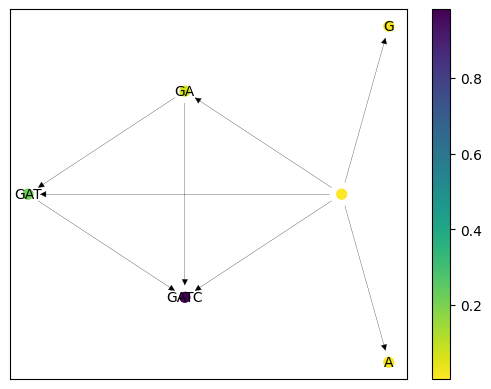

In [19]:
plot_search_graph(ecoli_guesses, label_mean_min=0.0001);


In [10]:
assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
geobacillus = nm.load_pileup("../data/geobacillus/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_1") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 5) \
    .filter(pl.col("fraction_mod") > 0.85) 

In [11]:
sequence = assembly.assembly["contig_1"]
padding = 10
methylation_index_fwd = geobacillus \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = geobacillus \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences = methylation_sequences_fwd + methylation_sequences_rev

In [12]:
gb_graph, gb_guesses = find_best_guesses(
    methylation_sequences,
    sequence,
    geobacillus,
    min_kl=0.2
)

DEBUG: ..................... | BetaBernoulliModel(alpha=26708, beta=7688732) 
DEBUG: .........GATC........ | BetaBernoulliModel(alpha=19853, beta=6585) 
DEBUG: .........GAT......... | BetaBernoulliModel(alpha=19859, beta=124175) 
DEBUG: .........GATC........ | BetaBernoulliModel(alpha=19853, beta=6585) 
DEBUG: .........GA.......... | BetaBernoulliModel(alpha=19882, beta=453846) 
INFO: .........GATC........, 6855 sequences remaining (25.67 %)
INFO: Continuing search
DEBUG: ..................... | BetaBernoulliModel(alpha=26708, beta=7688732) 
DEBUG: .....G............... | BetaBernoulliModel(alpha=8226, beta=1685078) 
DEBUG: .....GA.GAAG......... | BetaBernoulliModel(alpha=1778, beta=2944) 
DEBUG: .....GA.GAA.......... | BetaBernoulliModel(alpha=1780, beta=15504) 
DEBUG: .....GA.GAAG......... | BetaBernoulliModel(alpha=1778, beta=2944) 
DEBUG: .....GA.GA........... | BetaBernoulliModel(alpha=1743, beta=36595) 
INFO: .....GA.GAAGC........, 5764 sequences remaining (21.58 %)
INFO: Continu

In [13]:
gb_guesses

['.........GATC........',
 '.....GA.GAAGC........',
 '......CCAAAT.........',
 '.....GA.GAAGT........',
 '......ACCCA..........',
 '.....GG.GAAGC........',
 '.....GG.GAAGT........']

In [14]:
nxgraph_to_dataframe(gb_graph)


sequence,model,mean
str,object,f64
"""GG..GCGATCATG.…","BetaBernoulliModel(alpha=4, beta=1)",0.8
"""......CCAAAT..…","BetaBernoulliModel(alpha=2538, beta=648)",0.79661
""".....GA.GAAGC.…","BetaBernoulliModel(alpha=1092, beta=331)",0.767393
""".........GATC.…","BetaBernoulliModel(alpha=19853, beta=6585)",0.750927
"""GG..GCGATCATG.…","BetaBernoulliModel(alpha=3, beta=1)",0.75
""".....GG.GAAGC.…","BetaBernoulliModel(alpha=442, beta=204)",0.684211
"""GG..GCGATCATG.…","BetaBernoulliModel(alpha=2, beta=1)",0.666667
"""GG..GCGATCATG.…","BetaBernoulliModel(alpha=2, beta=1)",0.666667
""".....GA.GAAGT.…","BetaBernoulliModel(alpha=714, beta=361)",0.664186


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f497c0839a0>


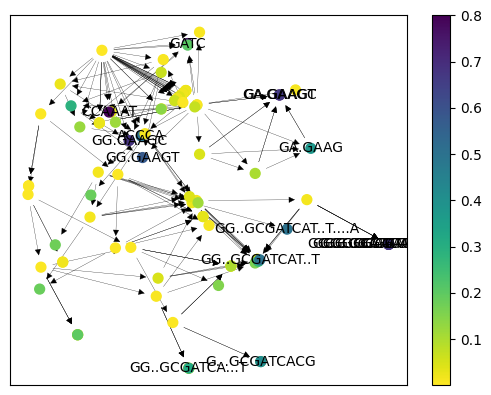

In [15]:
plot_search_graph(gb_graph)

In [52]:
assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mruber = nm.load_pileup("../data/mruber/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_1") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 10) \
    .filter(pl.col("fraction_mod") > 0.80) 

In [53]:
sequence = assembly.assembly["contig_1"]
padding = 13
methylation_index_fwd = mruber \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = mruber \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences = methylation_sequences_fwd + methylation_sequences_rev

In [57]:
mr_graph, mr_guesses = find_best_guesses(
    methylation_sequences,
    sequence,
    mruber,
    min_kl=0.2,
    padding = padding,
    cdf_position = 0.7
)

DEBUG: ........................... | BetaBernoulliModel(alpha=47601, beta=6147337) 
DEBUG: ............GA............. | BetaBernoulliModel(alpha=29469, beta=285292) 
DEBUG: .........C..GA............. | BetaBernoulliModel(alpha=18311, beta=97139) 
DEBUG: ............G.............. | BetaBernoulliModel(alpha=29874, beta=1933371) 
DEBUG: .........CT.GA[TG]............ | BetaBernoulliModel(alpha=14033, beta=13901) 
DEBUG: .........CT.GA[TG]............ | BetaBernoulliModel(alpha=14033, beta=13901) 
DEBUG: .........CT.GA............. | BetaBernoulliModel(alpha=14069, beta=26578) 
INFO: .........CTCGAG............, 34861 sequences remaining (73.24 %)
INFO: Continuing search
DEBUG: ........................... | BetaBernoulliModel(alpha=47601, beta=6147337) 
DEBUG: ............GA............. | BetaBernoulliModel(alpha=29469, beta=285292) 
DEBUG: ............G.............. | BetaBernoulliModel(alpha=29874, beta=1933371) 
DEBUG: ............GA............. | BetaBernoulliModel(alpha=29469, 

In [58]:
mr_guesses

['.........CTCGAG............',
 '............GATC...........',
 '..........TTAA.............',
 '............AATT...........',
 '..........GGGAGC...........',
 '..........GGCA......TGG....']

In [59]:
nxgraph_to_dataframe(mr_graph)

sequence,model,mean
str,object,f64
"""..........GGCA…","BetaBernoulliModel(alpha=1229, beta=10)",0.991929
"""..........GGGA…","BetaBernoulliModel(alpha=1811, beta=67)",0.964324
""".........CTCGA…","BetaBernoulliModel(alpha=6692, beta=429)",0.939756
"""............AA…","BetaBernoulliModel(alpha=5534, beta=648)",0.89518
""".........CTCGA…","BetaBernoulliModel(alpha=11888, beta=1561)",0.883932
"""..........TTAA…","BetaBernoulliModel(alpha=4085, beta=555)",0.880388
""".........CTCGA…","BetaBernoulliModel(alpha=12740, beta=2326)",0.845613
"""..........TTAA…","BetaBernoulliModel(alpha=772, beta=152)",0.835498
""".........CTCGA…","BetaBernoulliModel(alpha=5718, beta=1211)",0.825227


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f4937199b20>


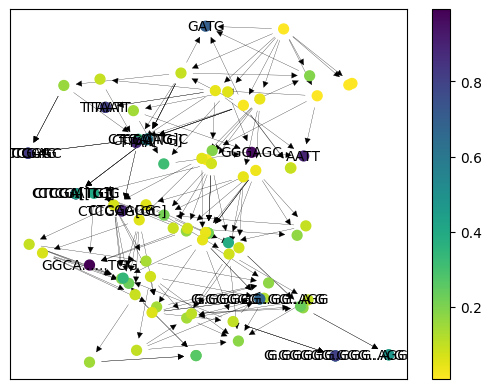

In [60]:
plot_search_graph(mr_graph, label_mean_min = 0.50)